# RCC model error analysis

Olatomiwa O. Bifarin

## Table of Contents
<a id="0"></a>
- [The Datasets](#1) <br>
- [ML Performance](#2) <br>
- [Confusion Matrix](#3)<br>
- [SHAP Analysis](#4)<br>
- [Decision Path Comparison](#5)<br>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import sklearn
import autosklearn
import shap
import openpyxl
import PipelineProfiler

#To ignore warning
import warnings
warnings.filterwarnings('ignore')

In [3]:
# numpy random seed.
np.random.seed(42)

## The Dataset
<a id="1"></a>

**Load and transform metabolomic dataset**

In [4]:
train_cohort = pd.read_excel('data/RCC_train_dataframe.xlsx')

In [5]:
train_cohort.head()

,hippurate-mannitol,Dibutylamine,hippuric acid,2-mercaptobenzothiazole,N-acetyl-glucosaminic acid,2-phenylacetamide,lys-Ile/lys-leu,Groups
0,3.800828e+06,51941.621700,21718.888030,13702.776060,109106.362391,7.108177e+06,9.556435e+05,0
1,3.516090e+06,362606.040476,67941.163070,78157.142221,300268.835200,5.124477e+06,1.402297e+06,1
2,6.431969e+05,104382.252294,19009.797187,1693.109469,42199.831666,3.812771e+06,2.689574e+03,0
3,7.281759e+05,81069.723681,45840.760919,1474.578607,135713.061180,5.615746e+06,1.794539e+04,0
4,6.457731e+03,309202.627175,445.362685,9147.539425,935.025788,2.728579e+05,6.660376e+04,1


In [6]:
# Separate target and features
target = "Groups" # Replace with your target column name.
X_train = train_cohort.drop(target, axis=1)
X_train =(X_train - X_train.mean(axis=0))/X_train.std(axis=0) #autoscaling
y_train = train_cohort[target]

In [7]:
print(f"There are {y_train.tolist().count(0)} healthy controls samples") 
print(f"There are {y_train.tolist().count(1)} RCC samples")

There are 140 healthy controls samples
There are 64 RCC samples


In [8]:
X_train.head()

,hippurate-mannitol,Dibutylamine,hippuric acid,2-mercaptobenzothiazole,N-acetyl-glucosaminic acid,2-phenylacetamide,lys-Ile/lys-leu
0,1.785974,-0.551343,0.199571,-0.074443,-0.296218,1.925620,0.311555
1,1.586772,1.334980,2.069200,0.917716,0.923021,1.002573,0.883304
2,-0.423095,-0.232929,0.089992,-0.259311,-0.722950,0.392216,-0.908297
3,-0.363644,-0.374480,1.175269,-0.262674,-0.126520,1.231168,-0.888768
4,-0.868556,1.010720,-0.660915,-0.144563,-0.986138,-1.254962,-0.826482


**Load test set**

In [9]:
test_cohort = pd.read_excel('data/RCC_test_dataframe.xlsx')
X_test = test_cohort.drop(target, axis=1)
X_test =(X_test - X_test.mean(axis=0))/X_test.std(axis=0) #autoscaling
y_test = test_cohort[target]

### [table of contents](#0)

## ML performance
<a id="2"></a>

In [10]:
import pickle

model_filename = 'askl_RCC_600.pkl'

# Load the model from the file
with open(model_filename, 'rb') as model_file:
    loaded_model = pickle.load(model_file)

In [13]:
from sklearn.metrics import confusion_matrix

estimator_askl = loaded_model

# ROC score
prediction = estimator_askl.predict_proba(X_test)
roc_askl = roc_auc_score(y_test, prediction[:, 1])
print("AutoML ROC-AUC test set: %0.2f" %(roc_askl))

# Accuracy
y_pred = estimator_askl.predict(X_test)
#acc_askl = accuracy_score(y_test, y_pred)
#print("AutoML Accuracy test set: %0.2f" %(acc_askl))

# Confusion matrix
print(f"AutoML confusion matrix: {confusion_matrix(y_test, y_pred)}")

AutoML ROC-AUC test set: 0.97
AutoML confusion matrix: [[31  3]
 [ 2 16]]


### [table of contents](#0)

## Confusion Matrix
<a id="3"></a>

In [14]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[31,  3],
       [ 2, 16]])

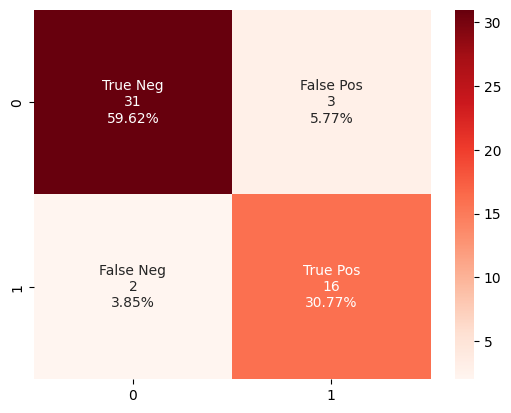

In [15]:
# Plot confusion matrix.

import seaborn as sns

group_names = ["True Neg","False Pos","False Neg","True Pos"]

group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', cmap='Reds'); #Blues

In [16]:
# merging predicted samples with ground truth. 
list_of_tuples = list(zip(y_pred, y_test))
error_list = pd.DataFrame(list_of_tuples, 
                  columns = ['Prediction', 'Label'])
error_list.head()

,Prediction,Label
0,0,0
1,0,1
2,1,1
3,0,0
4,0,0


`0` is healthy control while `1` is RCC samples. 

**True Positive Samples: RCC samples classified as a RCC**

In [18]:
# True positive
tp = error_list.loc[(error_list['Prediction'] == 1) & (error_list['Label'] == 1)]
# get the index as a list
tp_list = tp.index.tolist()
print(f"Theere are {len(tp_list)} true positives, and these are their indices: {tp_list}.")

Theere are 16 true positives, and these are their indices: [2, 8, 9, 15, 17, 18, 19, 21, 28, 31, 35, 36, 38, 45, 46, 47].


**False Negative Samples: RCC samples classified as Healthy**

In [19]:
# True positive
fn = error_list.loc[(error_list['Prediction'] == 0) & (error_list['Label'] == 1)]
fn_list = fn.index.tolist()

print(f"Theere are {len(fn_list)} false negatives, and these are their indices: {fn_list}.")

Theere are 2 false negatives, and these are their indices: [1, 37].


**True Negative Sample: Healthy controls classified as Healthy controls**

In [21]:
# True negative
tn = error_list.loc[(error_list['Prediction'] == 0) & (error_list['Label'] == 0)]
# get the index as a list
tn_list = tn.index.tolist()

print(f"Theere are {len(tn_list)} true negatives, and these are their indices: {tn_list}.")

Theere are 31 true negatives, and these are their indices: [0, 3, 4, 5, 7, 10, 11, 12, 13, 14, 16, 20, 22, 23, 24, 25, 26, 27, 29, 30, 32, 33, 34, 39, 41, 42, 44, 48, 49, 50, 51].


**False Positive Samples: Healthy controls classified as RCC samples**

In [22]:
# False positive
fp = error_list.loc[(error_list['Prediction'] == 1) & (error_list['Label'] == 0)]
# get the index as a list
fp_list = fp.index.tolist()

print(f"Theere are {len(fp_list)} false negatives, and these are their indices: {fp_list}.")

Theere are 3 false negatives, and these are their indices: [6, 40, 43].


### [table of contents](#0)

## SHAP Analysis
<a id="4"></a>

In [27]:
import shap
shap.initjs()

# Create a wrapper function for estimator_askl.predict_proba 
# that converts NumPy arrays back to pandas DataFrames:
def predict_proba_wrapper(X):
    X_df = pd.DataFrame(X, columns=X_train.columns)
    return estimator_askl.predict_proba(X_df)

In [28]:
#estimator_askl.predict_proba or just use the wrapper.

X_train_summary = shap.kmeans(X_train.values, 10)
# Model baseline: Use X_train_summary to summarize the training set or use whole train data.
explainer = shap.KernelExplainer(predict_proba_wrapper, X_train_summary, 
                                 link='identity', seed=42) #'logit?'

shap_values = explainer.shap_values(X_test.values, seed=42) #X_trainDF, X_testDF

  0%|          | 0/52 [00:00<?, ?it/s]

In [53]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[1].shape}')

length of SHAP values: 2
Shape of each element: (52, 7)


**SHAP decision plot for all samples**

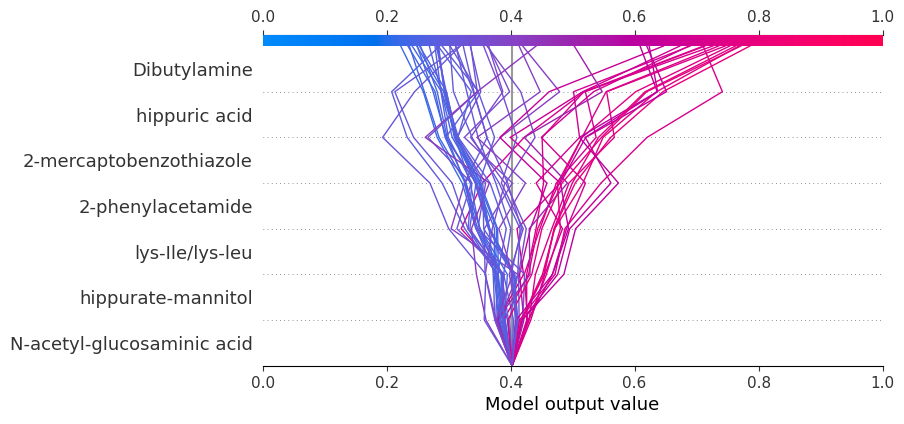

In [54]:
# create a shap decision plot
shap.decision_plot(explainer.expected_value[1], 
                   shap_values[1], 
                   feature_names=list(X_test.columns), 
                   link='identity', xlim=(0, 1))

**True positive _vs_ False negatives**

*True Positive*

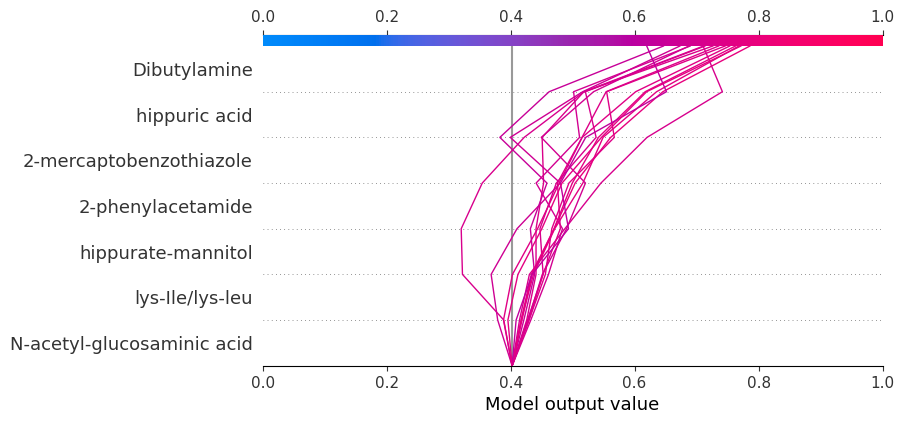

In [87]:
# True Positives
tp_shap_values = np.array([shap_values[1][i] for i in tp_list])
tp_X_test = X_test.iloc[tp_list]

shap.decision_plot(explainer.expected_value[1], tp_shap_values, 
                   tp_X_test, link='identity', xlim=(0, 1))

# Save the plot
#plt.savefig("Decision_plot_TP.svg")
#plt.clf()

*False Negative*

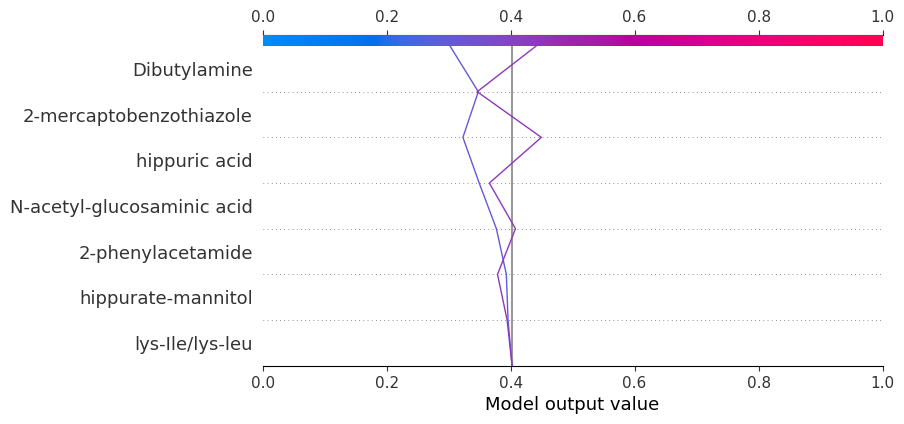

In [88]:
# False Negatives
fn_shap_values = np.array([shap_values[1][i] for i in fn_list])
fn_X_test = X_test.iloc[fn_list]

shap.decision_plot(explainer.expected_value[1], fn_shap_values, 
                   fn_X_test, link='identity', xlim=(0, 1))

# Save the plot
#plt.savefig("Decision_plot_FN.svg")
#plt.clf()

In [32]:
def feature_order(X_test, shap_values):
    # Get feature names
    feature_names = X_test.columns

    # Compute the sum of absolute SHAP values for each feature
    sum_abs_shap_values = np.sum(np.abs(shap_values), axis=0)

    # Create a DataFrame for easy manipulation
    df = pd.DataFrame(list(zip(feature_names, sum_abs_shap_values)), columns=['feature', 'sum_abs_shap_values'])

    # Sort the DataFrame by the sum of absolute SHAP values in descending order
    df = df.sort_values(by='sum_abs_shap_values', ascending=False)

    # Return the ordered features
    return df['feature']

Kendall's Tau: 0.6190476190476191
P-value: 0.06904761904761905


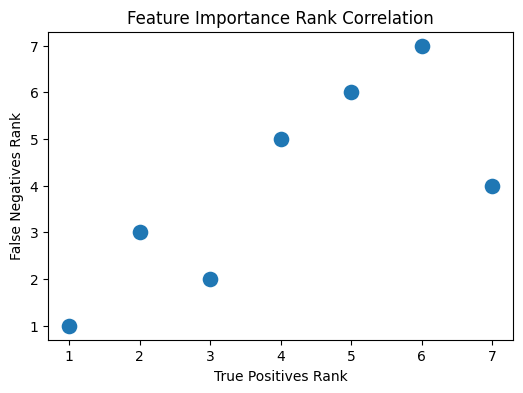

In [89]:
from scipy.stats import kendalltau
import seaborn as sns

# Get ordered features for true positives and false negatives
tp_ordered_features = feature_order(tp_X_test, tp_shap_values)
fn_ordered_features = feature_order(fn_X_test, fn_shap_values)

# Convert to ranks
tp_ranks = pd.Series(range(1, len(tp_ordered_features) + 1), index=tp_ordered_features)
fn_ranks = pd.Series(range(1, len(fn_ordered_features) + 1), index=fn_ordered_features)

# Align the two series on feature names
aligned_tp_ranks, aligned_fn_ranks = tp_ranks.align(fn_ranks, join='inner')

# Compute Kendall's Tau and p-value
tau, p_value = kendalltau(aligned_tp_ranks, aligned_fn_ranks)

# Print Kendall's Tau and p-value
print("Kendall's Tau:", tau)
print("P-value:", p_value)

# Plot a scatter plot of the ranks
plt.figure(figsize=(6, 4))
sns.scatterplot(x=aligned_tp_ranks, y=aligned_fn_ranks, s=150)
plt.xlabel('True Positives Rank')
plt.ylabel('False Negatives Rank')
plt.title('Feature Importance Rank Correlation')

# Save the plot
#plt.savefig("FNvsTP_correlation.svg")
#plt.clf()

plt.show()

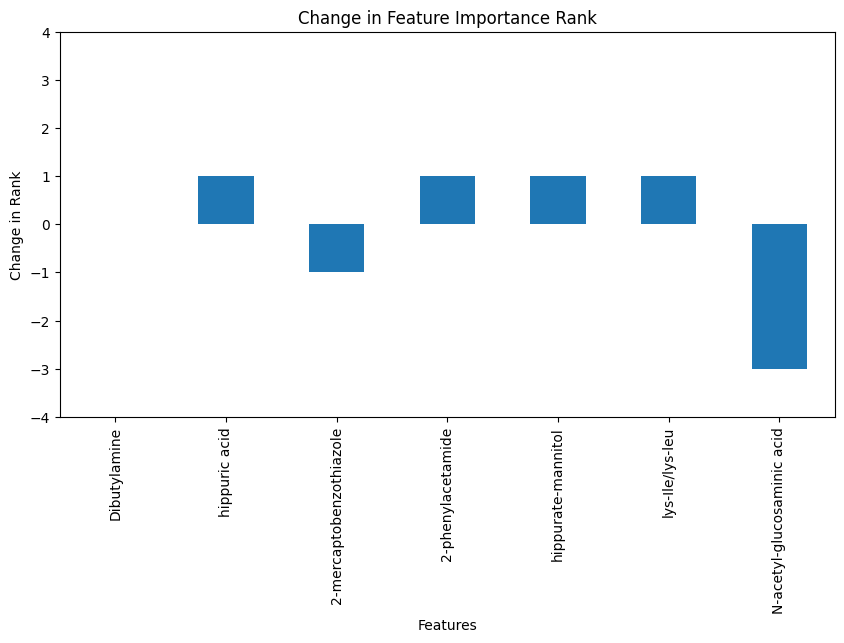

In [94]:
# Assuming you have two ordered feature lists: tp_ordered_features and fn_ordered_features

# Convert to ranks
tp_ranks = pd.Series(range(1, len(tp_ordered_features) + 1), index=tp_ordered_features)
fn_ranks = pd.Series(range(1, len(fn_ordered_features) + 1), index=fn_ordered_features)

# Align the two series on feature names
aligned_tp_ranks, aligned_fn_ranks = tp_ranks.align(fn_ranks, join='inner')

# Compute the change in ranks
rank_change = aligned_fn_ranks - aligned_tp_ranks

# Plot a bar chart of the rank changes
plt.figure(figsize=(10, 5))

rank_change.plot(kind='bar')
plt.ylim(-4, 4)
plt.xlabel('Features')
plt.ylabel('Change in Rank')
plt.title('Change in Feature Importance Rank')

# Save the plot
#plt.savefig("FNvsTP_change_in_rank.svg")
plt.show()

**True negative _vs_ False positives**

*True Negative*

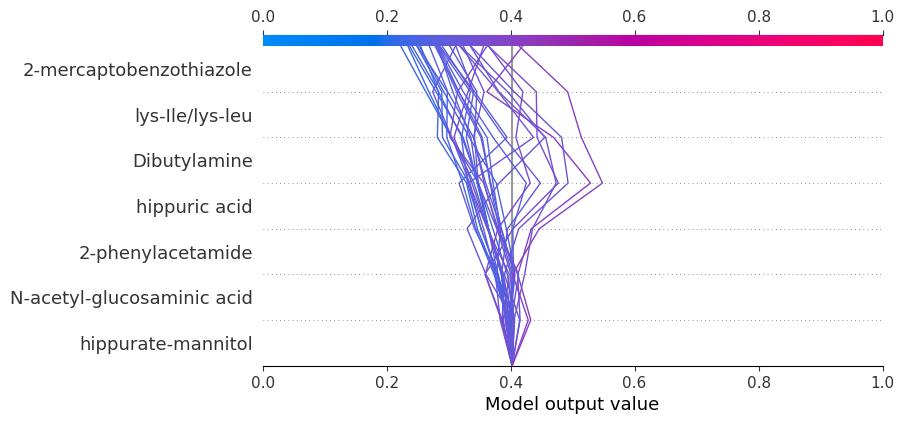

<Figure size 640x480 with 0 Axes>

In [77]:
# True Negatives
tn_shap_values = np.array([shap_values[1][i] for i in tn_list])
tn_X_test = X_test.iloc[tn_list]

shap.decision_plot(explainer.expected_value[1], tn_shap_values, 
                   tn_X_test, link='identity', xlim=(0, 1))

# Save the plot
#plt.savefig("Decision_plot_TN.svg")
#plt.clf()

*False Positive*

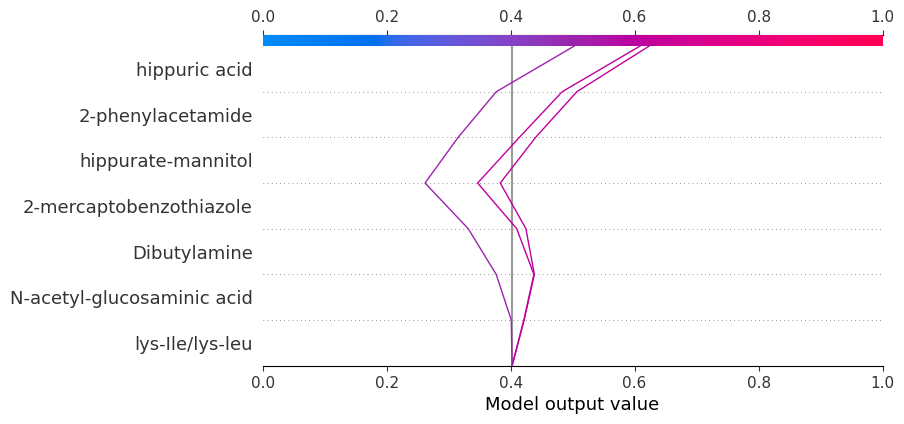

In [58]:
# False Positive
fp_shap_values = np.array([shap_values[1][i] for i in fp_list])
fp_X_test = X_test.iloc[fp_list]

shap.decision_plot(explainer.expected_value[1], fp_shap_values, 
                   fp_X_test, link='identity', xlim=(0, 1))

Kendall's Tau: -0.14285714285714288
P-value: 0.7726190476190476


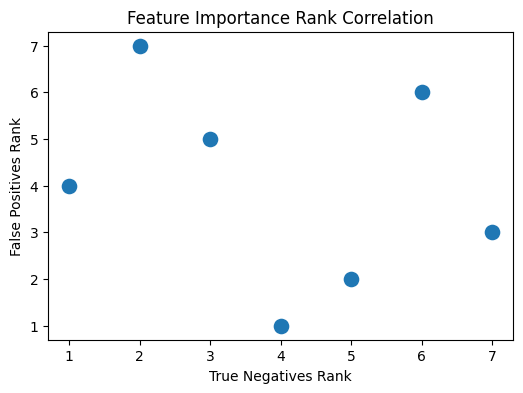

In [85]:
# Get ordered features for true positives and false negatives
tn_ordered_features = feature_order(tn_X_test, tn_shap_values)
fp_ordered_features = feature_order(fp_X_test, fp_shap_values)

# Convert to ranks
tn_ranks = pd.Series(range(1, len(tn_ordered_features) + 1), index=tn_ordered_features)
fp_ranks = pd.Series(range(1, len(fp_ordered_features) + 1), index=fp_ordered_features)

# Align the two series on feature names
aligned_tn_ranks, aligned_fp_ranks = tn_ranks.align(fp_ranks, join='inner')

# Compute Kendall's Tau and p-value
tau, p_value = kendalltau(aligned_tn_ranks, aligned_fp_ranks)

# Print Kendall's Tau and p-value
print("Kendall's Tau:", tau)
print("P-value:", p_value)

# Plot a scatter plot of the ranks
plt.figure(figsize=(6, 4))
sns.scatterplot(x=aligned_tn_ranks, y=aligned_fp_ranks, s=150)
plt.xlabel('True Negatives Rank')
plt.ylabel('False Positives Rank')
plt.title('Feature Importance Rank Correlation')

# Save the plot
#plt.savefig("TNvsFP_correlation.svg")
#plt.clf()
plt.show()

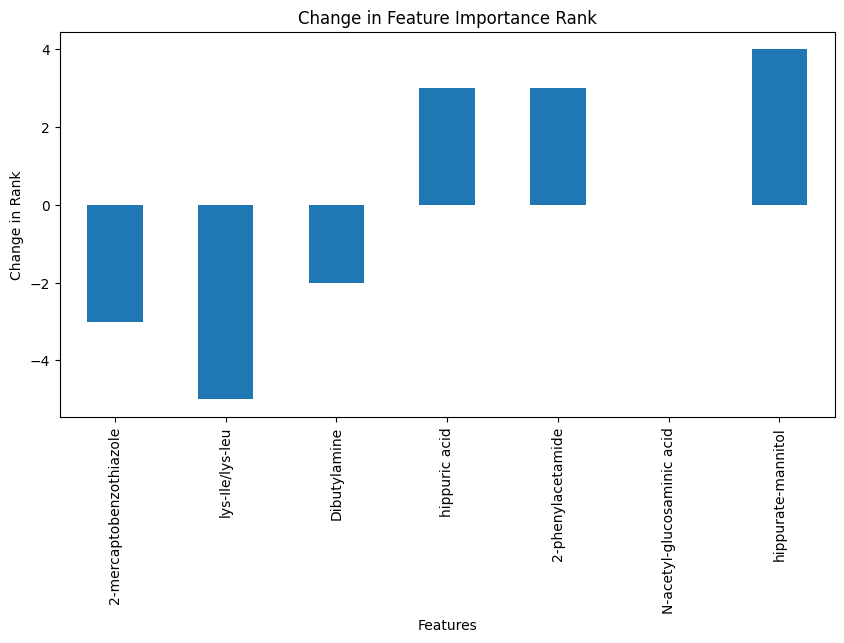

In [86]:
# Convert to ranks
tn_ranks = pd.Series(range(1, len(tn_ordered_features) + 1), index=tn_ordered_features)
fp_ranks = pd.Series(range(1, len(fp_ordered_features) + 1), index=fp_ordered_features)

# Align the two series on feature names
aligned_tn_ranks, aligned_fp_ranks = tn_ranks.align(fp_ranks, join='inner')

# Compute the change in ranks
rank_change = aligned_tn_ranks - aligned_fp_ranks

# Plot a bar chart of the rank changes
plt.figure(figsize=(10, 5))
rank_change.plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Change in Rank')
plt.title('Change in Feature Importance Rank')

# Save the plot
#plt.savefig("TNvsFP_change_in_rank.svg")
plt.show()

**Typical prediction path**

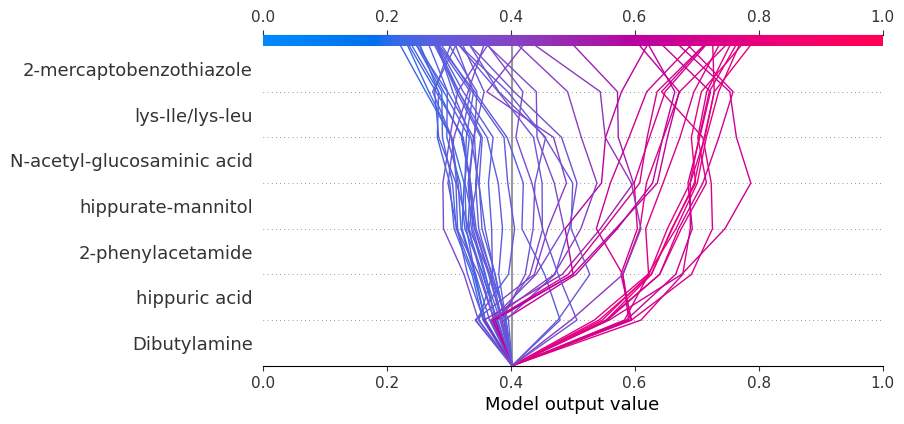

In [60]:
# create a shap decision plot
shap.decision_plot(explainer.expected_value[1], 
                   shap_values[1], 
                   feature_names=list(X_test.columns), 
                   link='identity', xlim=(0, 1),
                   feature_order='hclust')  # use 'hclust' in feature_order

### [table of contents](#0)

## Decision Path Comparison
<a id="5"></a>

**Compare decision path for different models**

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix

def evaluate_model(model, X_train, y_train, X_test, y_test):
    
    # Train the model using cross_val_score
    scores_auc = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=5)

    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    preds = model.predict(X_test)

    # Calculate the test set ROC AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
    test_roc_auc = round(metrics.auc(fpr, tpr), 2)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, preds)

    return scores_auc.mean(), scores_auc.std(), test_roc_auc, cm

In [62]:
# Random forest:
RF = RandomForestClassifier(random_state=42)
train_mean, train_std, test_roc_auc, cm = evaluate_model(RF, 
                                                         X_train, 
                                                         y_train, 
                                                         X_test, 
                                                         y_test)

print(f"RF training set ROC AUC: {round(train_mean, 2)}+/-({round(train_std, 2)})")
print(f"RF test set ROC AUC: {test_roc_auc}")
print(f"RF test set confusion matrix: {cm}")

RF training set ROC AUC: 0.98+/-(0.03)
RF test set ROC AUC: 0.89
RF test set confusion matrix: [[32  2]
 [ 3 15]]


In [66]:
from sklearn.svm import SVC

# Create a SVC object
svm = SVC(probability=True, random_state=42)
train_mean, train_std, test_roc_auc, cm = evaluate_model(svm, 
                                                         X_train, 
                                                         y_train, 
                                                         X_test, 
                                                         y_test)

print(f"SVM training set ROC AUC: {round(train_mean, 2)}+/-({round(train_std, 2)})")
print(f"SVM test set ROC AUC: {test_roc_auc}")
print(f"SVM test set confusion matrix: {cm}")

SVM training set ROC AUC: 0.97+/-(0.03)
SVM test set ROC AUC: 0.89
SVM test set confusion matrix: [[32  2]
 [ 3 15]]


In [64]:
from sklearn.linear_model import LogisticRegression

# Create a LogisticRegression object
lg_clf = LogisticRegression(random_state=42)
train_mean, train_std, test_roc_auc, cm = evaluate_model(lg_clf, 
                                                         X_train, 
                                                         y_train, 
                                                         X_test, 
                                                         y_test)

print(f"Logistic regression training set ROC AUC: {round(train_mean, 2)}+/-({round(train_std, 2)})")
print(f"Logistic regression test set ROC AUC: {test_roc_auc}")
print(f"Logistic regression test set confusion matrix: {cm}")

Logistic regression training set ROC AUC: 0.97+/-(0.03)
Logistic regression test set ROC AUC: 0.89
Logistic regression test set confusion matrix: [[32  2]
 [ 3 15]]


In [71]:
from sklearn.neighbors import KNeighborsClassifier

# Create a KNeighborsClassifier object
knn = KNeighborsClassifier()
train_mean, train_std, test_roc_auc, cm = evaluate_model(knn, 
                                                         X_train, 
                                                         y_train, 
                                                         X_test, 
                                                         y_test)

print(f"k-NN training set ROC AUC: {round(train_mean, 2)}+/-({round(train_std, 2)})")
print(f"k-NN test set ROC AUC: {test_roc_auc}")
print(f"k-NN test set confusion matrix: {cm}")

k-NN training set ROC AUC: 0.96+/-(0.04)
k-NN test set ROC AUC: 0.84
k-NN test set confusion matrix: [[31  3]
 [ 4 14]]


  0%|          | 0/52 [00:00<?, ?it/s]

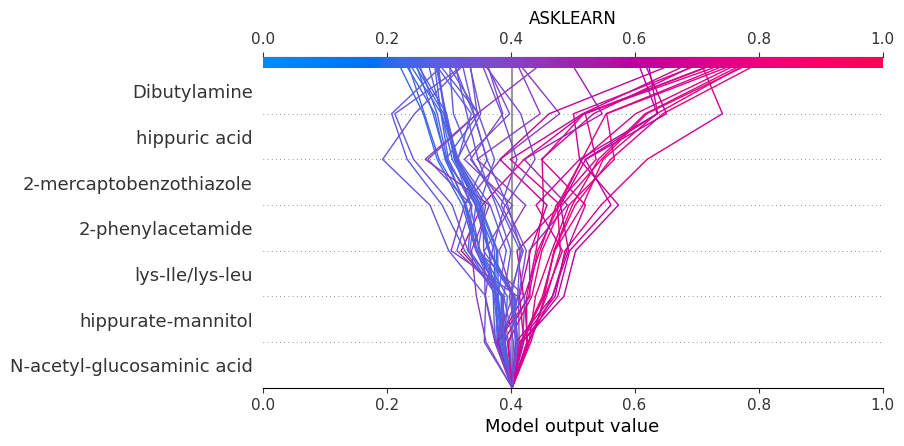

  0%|          | 0/52 [00:00<?, ?it/s]

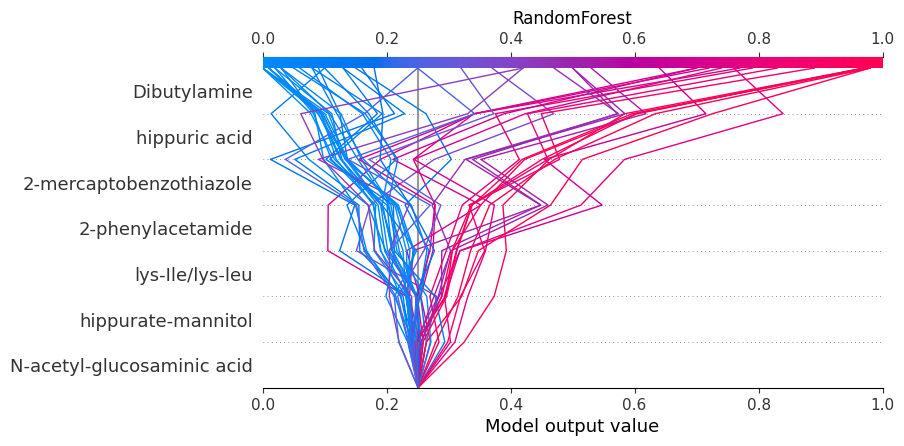

  0%|          | 0/52 [00:00<?, ?it/s]

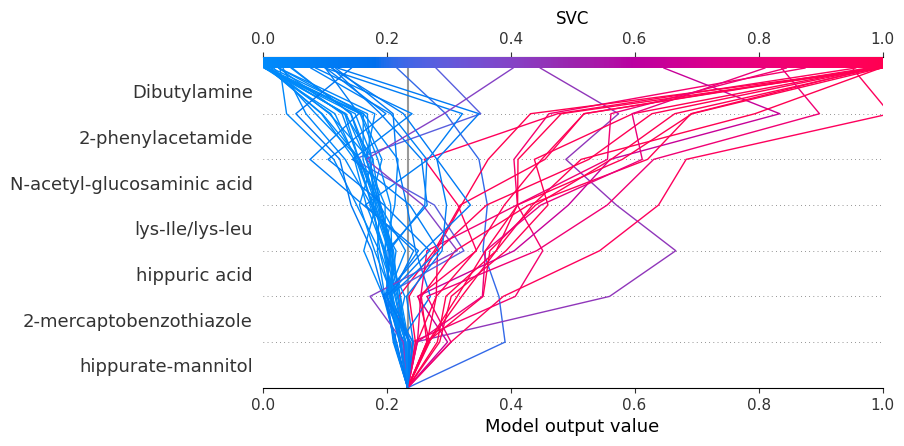

  0%|          | 0/52 [00:00<?, ?it/s]

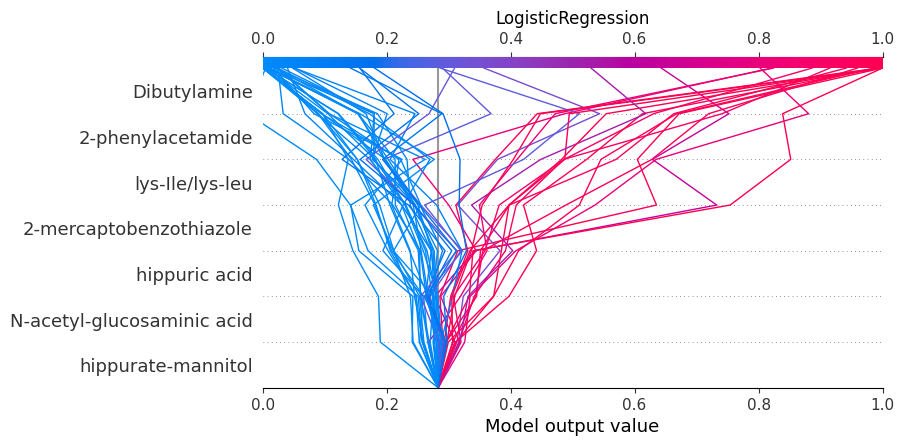

  0%|          | 0/52 [00:00<?, ?it/s]

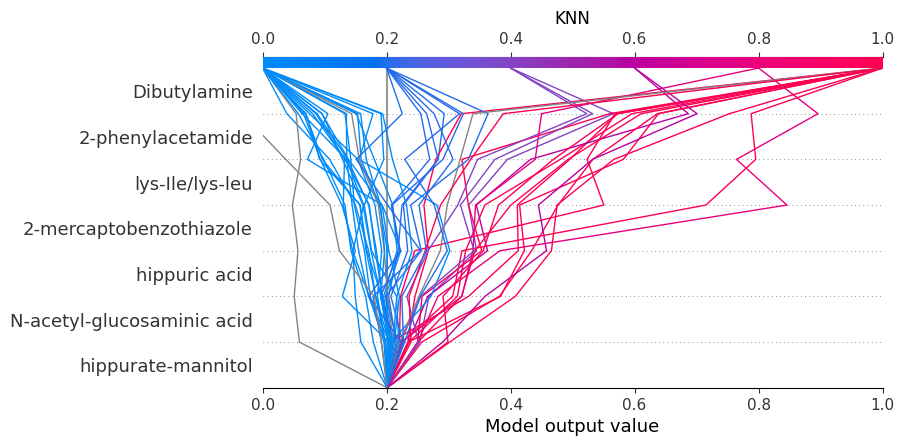

In [67]:
# List of classifiers
classifiers = {
    "ASKLEARN": estimator_askl,
    "RandomForest": RF,
    "SVC": svm,  # make sure SVC can output probabilities
    "LogisticRegression": lg_clf,
    "KNN": knn
}


# Compute and plot SHAP values for each classifier
for name, clf in classifiers.items():
    # Create a wrapper function for clf.predict_proba 
    # that converts NumPy arrays back to pandas DataFrames:
    def predict_proba_wrapper(X):
        X_df = pd.DataFrame(X, columns=X_train.columns)
        return clf.predict_proba(X_df)

    X_train_summary = shap.kmeans(X_train.values, 10)
    # Model baseline: Use X_train_summary to summarize the training set or use whole train data.
    explainer = shap.KernelExplainer(predict_proba_wrapper, X_train_summary, link='identity') #'logit?'

    shap_values = explainer.shap_values(X_test.values)

    # create a shap decision plot
    shap.decision_plot(explainer.expected_value[1], 
                       shap_values[1], 
                       feature_names=list(X_test.columns), 
                       link='identity', xlim=(0, 1),
                       title=name)  # add a title to each plot

In [75]:
# List of classifiers
classifiers = {
    "ASKLEARN": loaded_model,
    "RandomForest": RandomForestClassifier(random_state=42),
    "SVC": SVC(probability=True, random_state=42),  # make sure SVC can output probabilities
    "LogisticRegression": LogisticRegression(random_state=42),
    "KNN": KNeighborsClassifier()
}

# Train classifiers
for clf in classifiers.values():
    clf.fit(X_train, y_train)

# Initialize dictionary to store average SHAP values for each classifier
avg_shap_values = {}

# Compute and plot SHAP values for each classifier
for name, clf in classifiers.items():
    # Create a wrapper function for clf.predict_proba 
    # that converts NumPy arrays back to pandas DataFrames:
    def predict_proba_wrapper(X):
        X_df = pd.DataFrame(X, columns=X_train.columns)
        return clf.predict_proba(X_df)

    X_train_summary = shap.kmeans(X_train.values, 10)
    # Model baseline: Use X_train_summary to summarize the training set or use whole train data.
    explainer = shap.KernelExplainer(predict_proba_wrapper, X_train_summary, link='identity') #'logit?'

    shap_values = explainer.shap_values(X_test.values)

    # Compute average SHAP values
    avg_shap_values[name] = np.mean(shap_values, axis=0)

# Create a representative decision plot for each model
for name, avg_shap in avg_shap_values.items():
    shap.decision_plot(explainer.expected_value[1], 
                       avg_shap, 
                       feature_names=list(X_test.columns), 
                       link='identity', title=name)

ValueError: Unable to configure handler 'distributed_logfile'